In [1]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="2.tflite")
interpreter.allocate_tensors()

with open('2_labelmap.txt','r') as f:
    labels = f.read(-1)

labels = labels.splitlines()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
labels = np.array(labels)

In [4]:
# Test model on random input data.
input_shape = input_details[0]['shape']

#img = Image.open('WIN_20240502_11_34_42_Pro.jpg')

#img = Image.open('WIN_20240502_11_34_51_Pro.jpg')

img = Image.open('table.jpg')
#img = Image.open('table_objects.jpg')
data = np.array(img.resize(input_shape[1:3],Image.Resampling.LANCZOS))
data = data[np.newaxis,...]


In [5]:
input_details

[{'name': 'normalized_input_image_tensor',
  'index': 175,
  'shape': array([  1, 300, 300,   3], dtype=int32),
  'shape_signature': array([  1, 300, 300,   3], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.0078125, 128),
  'quantization_parameters': {'scales': array([0.0078125], dtype=float32),
   'zero_points': array([128], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [6]:
output_details

[{'name': 'TFLite_Detection_PostProcess',
  'index': 167,
  'shape': array([ 1, 10,  4], dtype=int32),
  'shape_signature': array([ 1, 10,  4], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'TFLite_Detection_PostProcess:1',
  'index': 168,
  'shape': array([ 1, 10], dtype=int32),
  'shape_signature': array([ 1, 10], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'TFLite_Detection_PostProcess:2',
  'index': 169,
  'shape': array([ 1, 10], dtype=int32),
  'shape_signature': array([ 1, 10], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': 

In [7]:
interpreter.set_tensor(input_details[0]['index'], data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
loc = interpreter.get_tensor(output_details[0]['index']).clip(0,1)
classes = interpreter.get_tensor(output_details[1]['index'])
scores = interpreter.get_tensor(output_details[2]['index'])
num_detections = interpreter.get_tensor(output_details[3]['index'])


In [8]:
loc.shape


(1, 10, 4)

In [9]:
locations = np.array(loc[0,:,:]*[img.height, img.width, img.height, img.width]).round().astype(np.uint32)

locations

array([[250, 342, 414, 586],
       [117,  25, 443, 621],
       [131, 195, 217, 415],
       [209,  68, 378, 202],
       [140, 190, 204, 249],
       [  0, 311, 123, 495],
       [203,  11, 471, 550],
       [  0, 440, 122, 640],
       [129, 164, 209, 319],
       [130, 168, 216, 264]], dtype=uint32)

In [10]:
classes = classes.astype(np.uint32)
classes

array([[86, 66, 83, 46, 83, 81, 66, 81, 83, 83]], dtype=uint32)

In [11]:
labels[classes[0]]

array(['scissors', 'dining table', 'book', 'cup', 'book', 'refrigerator',
       'dining table', 'refrigerator', 'book', 'book'], dtype='<U14')

In [12]:
scores

array([[0.48828125, 0.4765625 , 0.4140625 , 0.4140625 , 0.35546875,
        0.3203125 , 0.3203125 , 0.2890625 , 0.28125   , 0.25      ]],
      dtype=float32)

In [13]:
num_detections

array([10.], dtype=float32)

In [14]:
draw_img = img.copy()
drawing = ImageDraw.Draw(draw_img)
f = ImageFont.truetype('Courier New.ttf',18)

for v in range(locations.shape[0]):
    if scores[0,v] < 0.4:
        continue
    drawing.rectangle([locations[v,1], locations[v,0], locations[v,3],locations[v,2]],outline='green',width=2)
    drawing.text([locations[v,1]+4, locations[v,0]+2],fill='black', stroke_width=2, stroke_fill='yellow',font=f,  text=f'{labels[classes[0,v]]}@{scores[0,v]*100:.1f}%')


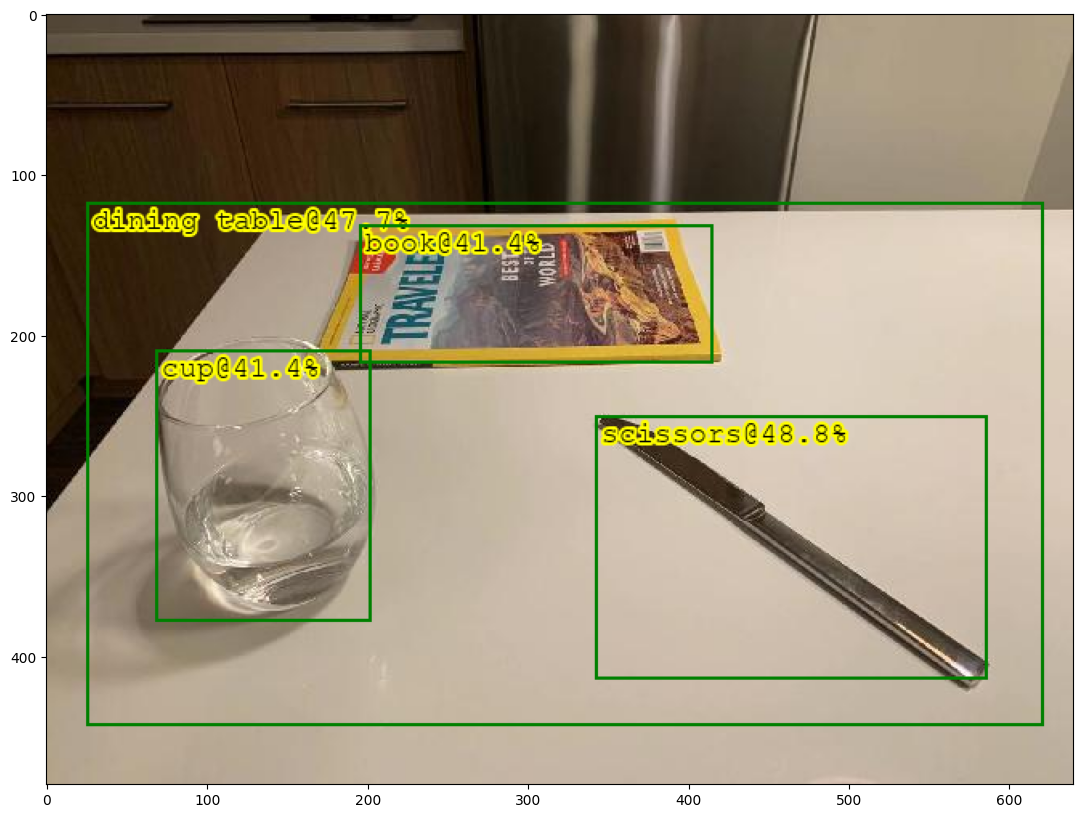

In [15]:
plt.figure(figsize=(14,10))
plt.imshow(draw_img)